In [2]:
using Plots
using WassersteinDictionaries, Distances, LinearAlgebra


In [178]:
c = (x,y) -> Distances.sqeuclidean(x,y)

n = 100
x = zeros(n,2)
y = zeros(n,2)

for i in 1:n
    r = -0.3*cos( 2π * i / n )*(cos( 4π * i / n ))^2 + 0.7
    x[i,:] .= [1,1] .+ [ r * cos( 2π * i / n ), r * sin( 2π * i / n ) ]
    y[i,:] .= -[1,1] .+ [ cos( 2π * i / n ), sin( 2π * i / n ) ]
end

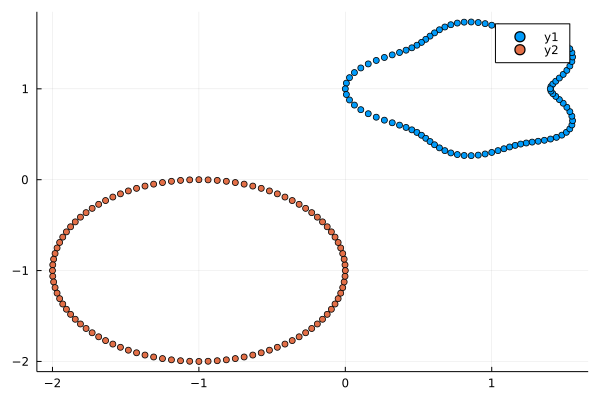

In [179]:
scatter( [ (x[i,1], x[i,2]) for i in 1:n ] )
scatter!( [ (y[i,1], y[i,2]) for i in 1:n ] )

In [180]:
log_α = [ log(1/n) for _ in 1:n ]
log_β = copy(log_α);

caches = ( VC = VectorCache(2,n),  )

ε = 5e-2

SP = SinkhornParameters(128, ε);

SP.debias = true
SP.update_potentials = true

u₀ = zeros(n)
v₀ = zeros(n)
log_d₁₀ = zeros(n)
log_d₂₀ = zeros(n);

In [181]:
sinkhorn_dvg_particles( x, y, log_α, log_β, c,
                        u₀, v₀, log_d₁₀, log_d₂₀,
                        SP, caches  )

7.804765798734612

In [182]:
w = zeros(n); v = zeros(n,2);
K = exp.(-LazyCost(x, y, c)./ε)

w .= exp.(u₀) .* (K * exp.(v₀))
v .= (exp.(u₀) .* (K * (exp.(v₀) .* y)) .- exp.(u₀) .* x .* (K * exp.(v₀))) ./ w;

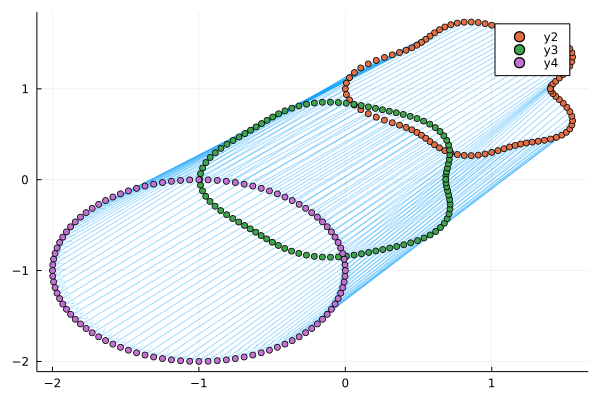

In [183]:
quiver(x[:,1],x[:,2],quiver=(v[:,1],v[:,2]) , linealpha = 0.2)
scatter!( [ (x[i,1], x[i,2]) for i in 1:n ] )
scatter!( [ (x[i,1] + 0.5*v[i,1], x[i,2]+ 0.5*v[i,2]) for i in 1:n ] )
scatter!( [ (y[i,1], y[i,2]) for i in 1:n ] )

In [184]:
x_c = (w' * x)' / sum(w)
v_c = (w' * v)' / sum(w)
W = diagm(w)
X = zero(x)
Y = zero(x)
for i in 1:n
    X[i,:] .= x[i,:] .- x_c
    Y[i,:] .= x[i,:] .+ v[i,:] .- x_c .- v_c
end

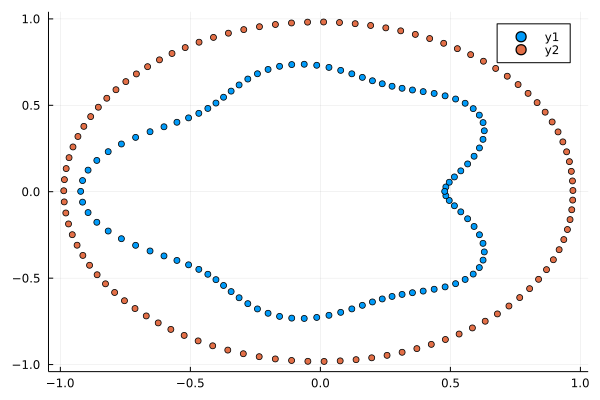

In [185]:
scatter( [ (X[i,1], X[i,2]) for i in 1:n ] )
scatter!( [ (Y[i,1], Y[i,2]) for i in 1:n ] )

In [165]:
F = svd( X'*W*Y )
U = F.U
Vᵗ = F.Vt

2×2 Matrix{Float64}:
 0.00107441   0.999999
 0.999999    -0.00107441

In [186]:
U*Vᵗ

2×2 Matrix{Float64}:
 1.0         -3.94866e-16
 3.9465e-16   1.0

In [187]:
Inv = inv( X'*W*X )
σ = 0.1
k = (x,y) -> exp(-Distances.sqeuclidean(x,y)/(2*σ^2))/(2π*σ^2)

#381 (generic function with 1 method)

In [188]:
function T(_x)
    #Vᵗ'*U'*(_x - x_c) + x_c + v_c           #rigid
    #((_x - x_c)'*Inv*X'*W*Y)' + x_c + v_c    #affine
    Δx = zero(_x)
    nrm = 0
    for i in 1:n
        kw = w[i] * k(_x, x[i,:])
        Δx .+= v[i,:] .* kw
        nrm += kw
    end
    return _x + Δx / nrm
end

T (generic function with 1 method)

In [189]:
n_t = n
x_t = rand(n_t,2) .* 2;
y_t = zero(x_t)
for i in 1:n_t
    x_t[i,:] .= x[i,:] # [1,1] .+ [ 0.2 * cos( 2π * i / n_t ), 0.2 * sin( 2π * i / n_t ) ]
    y_t[i,:] .= T(x_t[i,:])
end

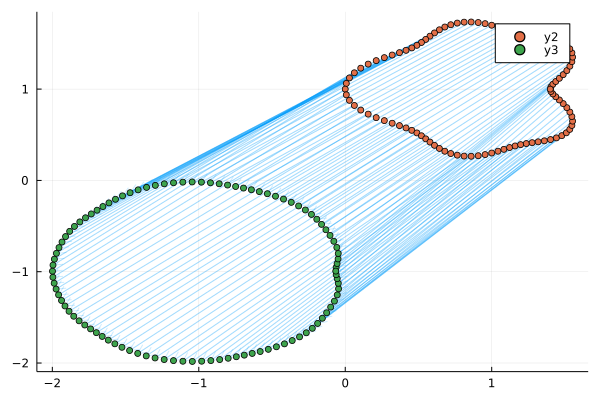

In [190]:
quiver(x_t[:,1],x_t[:,2],quiver=(y_t[:,1]-x_t[:,1],y_t[:,2]-x_t[:,2]), linealpha = 0.2)
scatter!( [ (x_t[i,1], x_t[i,2]) for i in 1:n_t ] )
scatter!( [ (y_t[i,1], y_t[i,2]) for i in 1:n_t ] )

In [600]:
function loss(x)
    sinkhorn_dvg_particles( x, y, log_α, log_β, c,
                            u₀, v₀, log_d₁₀, log_d₂₀,
                            SP, caches  )
end

loss (generic function with 1 method)

In [5]:
using Distances, ForwardDiff

loss(x)

1.521759712265432

In [8]:
dx = ForwardDiff.gradient(loss, x);

In [15]:
x₊ = x - dx;

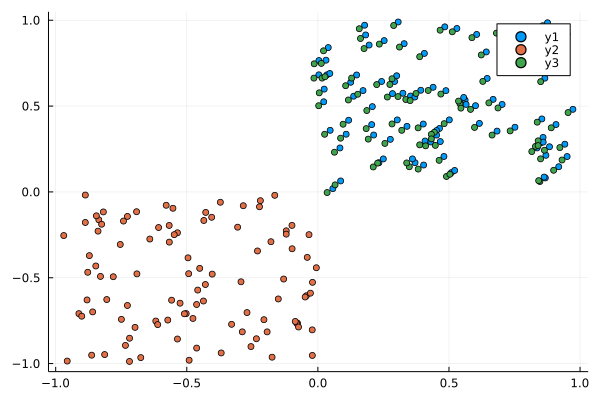

In [16]:
scatter( [ (x[i,1], x[i,2]) for i in 1:n ] )
scatter!( [ (y[i,1], y[i,2]) for i in 1:n ] )
scatter!( [ (x₊[i,1], x₊[i,2]) for i in 1:n ] )